# 1.通过卷积神经网络完成对fashion_mnist数据集的训练

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os,sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
x_val,x_train = x_train[:5000],x_train[5000:]
y_val,y_train = y_train[:5000],y_train[5000:]
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [3]:
# 进行标准化
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
x_train = x_train.reshape(-1,1)
x_train = stand.fit_transform(x_train).reshape(-1,28,28)
x_val = x_val.reshape(-1,1)
x_val = stand.transform(x_val).reshape(-1,28,28)
x_test = x_test.reshape(-1,1)
x_test = stand.transform(x_test).reshape(-1,28,28)

In [ ]:
# 搭建卷积神经神经网络,一般是两个卷积层加一个池化层
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=2)) # 经过最大池化之后，特征图的尺寸会较小，所以需要提升通道数来防止信息丢失
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Flatten()) # 将3维的图像展平层1维的
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(10,activation='softmax')) # 最后要分为10个类别，所以需要10个神经元，并用softmax输出概率
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

## 参数计算方法
1. 320 = 32*3*3 + 32
2. 9248 = 32*32*3*3 + 32
3. 18496 = 32*64*3*3 + 64
4. 36928 = 64*64*3*3 + 64

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
logdir = './cnn-relu-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)
output_model = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
             keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=10,min_delta=1e-4)
]

In [ ]:
history = model.fit(x_train,y_train,
                    epochs = 100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4137 - accuracy: 0.8479 - val_loss: 0.2790 - val_accuracy: 0.8978
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2563 - accuracy: 0.9069 - val_loss: 0.2406 - val_accuracy: 0.9092
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2160 - accuracy: 0.9201 - val_loss: 0.2117 - val_accuracy: 0.9236
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1871 - accuracy: 0.9321 - val_loss: 0.2186 - val_accuracy: 0.9232
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1637 - accuracy: 0.9396 - val_loss: 0.2104 - val_accuracy: 0.9222
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1453 - accuracy: 0.9456 - val_loss: 0.2061 - val_accuracy: 0.9246
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1280 - accuracy: 0.9521 - val_loss: 0.2268 - val_ac

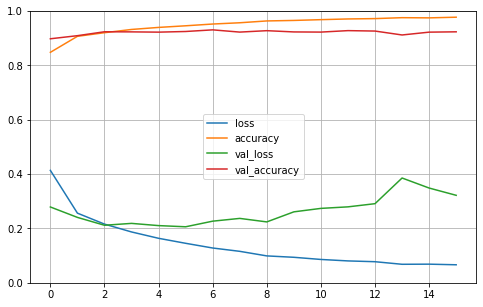

In [ ]:
def plot_learning_curves(history):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()
plot_learning_curves(history)

In [ ]:
# 如图所示，很明显发生了过拟合，所以测试集的精度比验证集上的精度低了许多
model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3711 - accuracy: 0.9195


[0.37105825543403625, 0.9194999933242798]

## 尝试把relu改为selu之后，看看是否能延缓过拟合

In [ ]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)
output_model = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
             keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3)
]

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu',input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2)) # 经过最大池化之后，特征图的尺寸会较小，所以需要提升通道数来防止信息丢失
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='selu'))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Flatten()) # 将3维的图像展平层1维的
model.add(layers.Dense(128,activation='selu'))
model.add(layers.Dense(10,activation='softmax')) # 最后要分为10个类别，所以需要10个神经元，并用softmax输出概率
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,
                    epochs = 100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4330 - accuracy: 0.8423 - val_loss: 0.3160 - val_accuracy: 0.8868
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2908 - accuracy: 0.8940 - val_loss: 0.3046 - val_accuracy: 0.8910
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2454 - accuracy: 0.9110 - val_loss: 0.2562 - val_accuracy: 0.9084
Epoch 4/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2112 - accuracy: 0.9234 - val_loss: 0.3056 - val_accuracy: 0.8968
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1833 - accuracy: 0.9331 - val_loss: 0.2443 - val_accuracy: 0.9132
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1595 - accuracy: 0.9428 - val_loss: 0.2810 - val_accuracy: 0.9042
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1375 - accuracy: 0.9515 - val_loss: 0.2582 - val_ac

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3291 - accuracy: 0.9176


[0.32909390330314636, 0.9175999760627747]

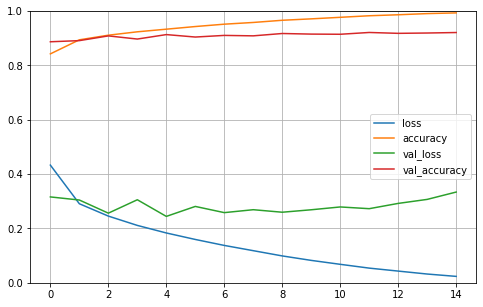

In [ ]:
# 由图所示，依然处于过拟合状态，可以适当减少层数，使模型变得更简单
def plot_learning_curves(history):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()
plot_learning_curves(history)

## 较少层数，使模型变得更简单，观察精度情况

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu',input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2)) # 经过最大池化之后，特征图的尺寸会较小，所以需要提升通道数来防止信息丢失
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Flatten()) # 将3维的图像展平层1维的
model.add(layers.Dense(128,activation='selu'))
model.add(layers.Dense(10,activation='softmax')) # 最后要分为10个类别，所以需要10个神经元，并用softmax输出概率
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
logdir = './cnn-selu-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)
output_model = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
             keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3)
]

In [ ]:
history = model.fit(x_train,y_train,
                    epochs = 100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4305 - accuracy: 0.8462 - val_loss: 0.3263 - val_accuracy: 0.8844
Epoch 2/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2952 - accuracy: 0.8935 - val_loss: 0.2824 - val_accuracy: 0.8996
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2498 - accuracy: 0.9103 - val_loss: 0.3184 - val_accuracy: 0.8778
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2202 - accuracy: 0.9205 - val_loss: 0.2547 - val_accuracy: 0.9094
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1967 - accuracy: 0.9295 - val_loss: 0.2437 - val_accuracy: 0.9112
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1748 - accuracy: 0.9375 - val_loss: 0.2412 - val_accuracy: 0.9156
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1557 - accuracy: 0.9444 - val_loss: 0.2415 - val_ac

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3220 - accuracy: 0.9147


[0.32198596000671387, 0.9146999716758728]

## 使用droupout来减少过拟合

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu',input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2)) # 经过最大池化之后，特征图的尺寸会较小，所以需要提升通道数来防止信息丢失
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Flatten()) # 将3维的图像展平层1维的
model.add(layers.Dense(128,activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation='softmax')) # 最后要分为10个类别，所以需要10个神经元，并用softmax输出概率
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
logdir = './cnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)
output_model = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
             keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

In [ ]:
history = model.fit(x_train,y_train,
                    epochs = 100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

In [ ]:
model.evaluate(x_test,y_test)

## 使用droupout来减少过拟合

In [9]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu',input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2)) # 经过最大池化之后，特征图的尺寸会较小，所以需要提升通道数来防止信息丢失
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.Conv2D(64,(3,3),padding='same',activation='selu'))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Flatten()) # 将3维的图像展平层1维的
model.add(layers.Dense(128,activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation='softmax')) # 最后要分为10个类别，所以需要10个神经元，并用softmax输出概率
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [10]:
logdir = './cnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
  os.mkdir(logdir)
output_model = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
             keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model,save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

In [11]:
history = model.fit(x_train,y_train,
                    epochs = 100,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6670 - accuracy: 0.7734 - val_loss: 0.3367 - val_accuracy: 0.8784
Epoch 2/100
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4405 - accuracy: 0.8506 - val_loss: 0.3112 - val_accuracy: 0.8888
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3760 - accuracy: 0.8720 - val_loss: 0.2820 - val_accuracy: 0.9002
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3445 - accuracy: 0.8798 - val_loss: 0.2701 - val_accuracy: 0.9048
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3157 - accuracy: 0.8919 - val_loss: 0.2618 - val_accuracy: 0.9086
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2963 - accuracy: 0.8973 - val_loss: 0.2525 - val_accuracy: 0.9126
Epoch 7/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2809 - accuracy: 0.9051 - val_loss: 0.2396 - val_ac

In [12]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2899 - accuracy: 0.9113


[0.2898588180541992, 0.911300003528595]